# Proyek Klasifikasi Gambar: A Dataset for Vegetable Identification
- **Nama:** Frisnadi
- **Email:** frisnadi1@gmail.com
- **ID Dicoding:** frisnadiyk

## Import Semua Packages/Library yang Digunakan

In [7]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.17.1


## Data Preparation

### Data Loading

#### Gabungkan Data Train dan Data Test ke Direktori yang Sama

In [9]:
import os
import shutil
import random

# Path awal dataset
dataset_path = "/kaggle/input/a-dataset-for-vegetable-identification/A Dataset for Vegetable Identification/Vegetable identification dataset/Vegetable identification dataset/Augmented dataset"

# Path untuk dataset yang dipisah
train_dir = "/kaggle/working/vegetables/dataset/train"
test_dir = "/kaggle/working/vegetables/dataset/test"

# Proporsi data train-test
train_ratio = 0.8  # 80% data untuk train, 20% untuk test

# Buat folder train dan test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Looping ke dalam folder kategori
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):  # Pastikan itu folder
        images = os.listdir(category_path)
        random.shuffle(images)  # Acak urutan gambar
        
        # Tentukan jumlah data untuk train & test
        train_size = int(len(images) * train_ratio)
        
        train_images = images[:train_size]
        test_images = images[train_size:]
        
        # Buat folder kategori di train & test
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Salin gambar ke folder train
        for img in train_images:
            src = os.path.join(category_path, img)
            dst = os.path.join(train_dir, category, img)
            shutil.copy2(src, dst)
        
        # Salin gambar ke folder test
        for img in test_images:
            src = os.path.join(category_path, img)
            dst = os.path.join(test_dir, category, img)
            shutil.copy2(src, dst)

print("Dataset berhasil dipisah menjadi train dan test!")


Dataset berhasil dipisah menjadi train dan test!


In [10]:
import os

# Path ke folder train
train_path = "vegetables/dataset/train"

# Loop semua folder dalam train_path
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)

    # Jika folder mengandung "Augmented", ubah namanya
    if "Augmented" in folder and os.path.isdir(folder_path):
        new_folder_name = folder.replace("Augmented ", "")  # Hapus kata "Augmented "
        new_folder_path = os.path.join(train_path, new_folder_name)

        os.rename(folder_path, new_folder_path)  # Ubah nama folder
        print(f"Folder {folder} diubah menjadi {new_folder_name}")


Folder Augmented Beans diubah menjadi Beans
Folder Augmented Ladies finger diubah menjadi Ladies finger
Folder Augmented eggplant diubah menjadi eggplant
Folder Augmented Pointed gourd diubah menjadi Pointed gourd
Folder Augmented Onion diubah menjadi Onion
Folder Augmented Potato diubah menjadi Potato


In [11]:
import os

# Path ke folder train
train_path = "vegetables/dataset/test"

# Loop semua folder dalam train_path
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)

    # Jika folder mengandung "Augmented", ubah namanya
    if "Augmented" in folder and os.path.isdir(folder_path):
        new_folder_name = folder.replace("Augmented ", "")  # Hapus kata "Augmented "
        new_folder_path = os.path.join(train_path, new_folder_name)

        os.rename(folder_path, new_folder_path)  # Ubah nama folder
        print(f"Folder {folder} diubah menjadi {new_folder_name}")


Folder Augmented Beans diubah menjadi Beans
Folder Augmented Ladies finger diubah menjadi Ladies finger
Folder Augmented eggplant diubah menjadi eggplant
Folder Augmented Pointed gourd diubah menjadi Pointed gourd
Folder Augmented Onion diubah menjadi Onion
Folder Augmented Potato diubah menjadi Potato


In [12]:
import os
import shutil

# Path ke folder utama
main_path = "."

# Loop semua item di dalam direktori utama
for item in os.listdir(main_path):
    item_path = os.path.join(main_path, item)

    # Hapus jika item adalah folder dan bukan "dataset"
    if os.path.isdir(item_path) and item != "vegetables":
        shutil.rmtree(item_path)  # Hapus folder dan isinya
        print(f"Folder {item} telah dihapus.")


Folder .virtual_documents telah dihapus.


#### Check number of images and resolution size

#### Plot gambar sampel untuk semua kelas

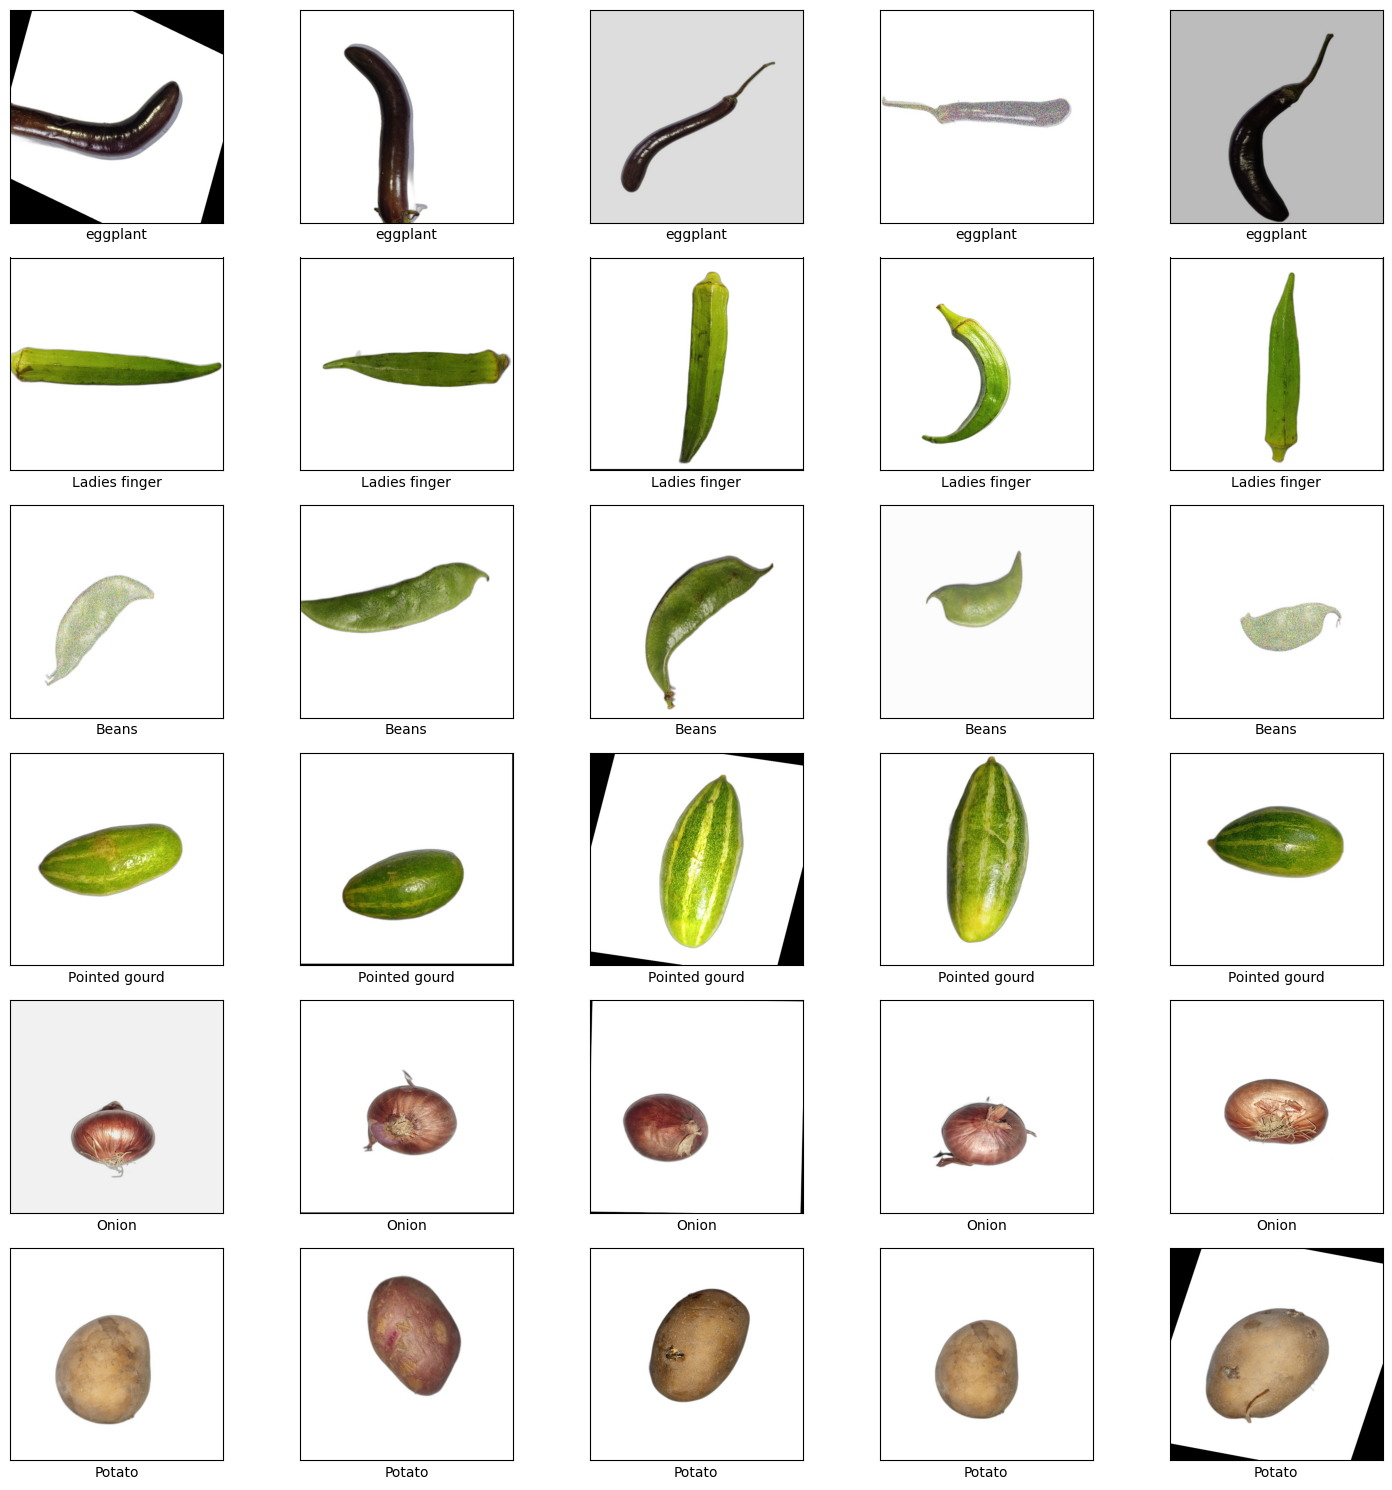

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
vegetable_images = {}

# Tentukan path sumber train
path = "vegetables/dataset"
train_path = os.path.join(path, "train")

# Menyimpan daftar gambar dalam setiap kelas di train set
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya folder yang diproses
        vegetable_images[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar dari setiap kelas
fig, axs = plt.subplots(len(vegetable_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(vegetable_images.keys()):
    images = np.random.choice(vegetable_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(train_path, class_name, image_name)
        img = Image.open(img_path)  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


#### Plot Distribusi gambar semua Kelas

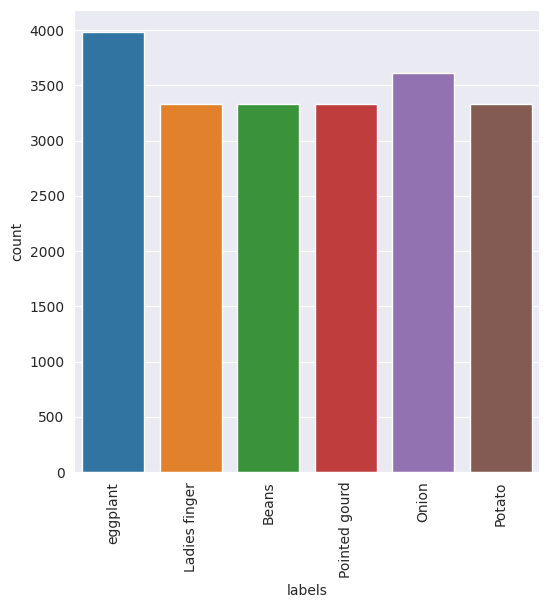

In [14]:
# Define source path
vegetables = "vegetables/dataset/train"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(vegetables):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
sns.countplot(x="labels", data=distribution_train)
plt.xticks(rotation=90) 
plt.show()

### Data Preprocessing

#### Split Dataset

In [15]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'vegetables/dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Beans            4166
Ladies finger    4166
Onion            4448
Pointed gourd    4166
Potato           4166
eggplant         5470
dtype: int64

In [16]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

print('train size', len(df_tr))
print('test size', len(df_te))

# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))

train size 21265
test size 5317

set    labels       
test   Beans             854
       Ladies finger     857
       Onion             866
       Pointed gourd     826
       Potato            820
       eggplant         1094
train  Beans            3312
       Ladies finger    3309
       Onion            3582
       Pointed gourd    3340
       Potato           3346
       eggplant         4376
dtype: int64 


                                                    path         labels    set
5968      vegetables/dataset/train/eggplant/aug_4074.jpg       eggplant  train
7845        vegetables/dataset/test/eggplant/aug_653.jpg       eggplant  train
1584        vegetables/dataset/test/eggplant/aug_802.jpg       eggplant  train
16814        vegetables/dataset/train/Beans/aug_3979.jpg          Beans  train
1822   vegetables/dataset/train/Pointed gourd/aug_246...  Pointed gourd  train


In [17]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "vegetables/dataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [18]:
import os

# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Define class paths
train_eggplant = os.path.join(TRAIN_DIR, "eggplant")
train_beans = os.path.join(TRAIN_DIR, "Beans")
train_ladies_finger = os.path.join(TRAIN_DIR, "Ladies finger")
train_pointed_gourd = os.path.join(TRAIN_DIR, "Pointed gourd")
train_potato = os.path.join(TRAIN_DIR, "Potato")
train_onion = os.path.join(TRAIN_DIR, "Onion")

test_eggplant = os.path.join(TEST_DIR, "eggplant")
test_beans = os.path.join(TEST_DIR, "Beans")
test_ladies_finger = os.path.join(TEST_DIR, "Ladies finger")
test_pointed_gourd = os.path.join(TEST_DIR, "Pointed gourd")
test_potato = os.path.join(TEST_DIR, "Potato")
test_onion = os.path.join(TEST_DIR, "Onion")

# Print the number of images in each class
print("Total number of Eggplant images in training set:", len(os.listdir(train_eggplant)))
print("Total number of Beans images in training set:", len(os.listdir(train_beans)))
print("Total number of Ladies Finger images in training set:", len(os.listdir(train_ladies_finger)))
print("Total number of Pointed Gourd images in training set:", len(os.listdir(train_pointed_gourd)))
print("Total number of Potato images in training set:", len(os.listdir(train_potato)))
print("Total number of Onion images in training set:", len(os.listdir(train_onion)))

print("Total number of Eggplant images in test set:", len(os.listdir(test_eggplant)))
print("Total number of Beans images in test set:", len(os.listdir(test_beans)))
print("Total number of Ladies Finger images in test set:", len(os.listdir(test_ladies_finger)))
print("Total number of Pointed Gourd images in test set:", len(os.listdir(test_pointed_gourd)))
print("Total number of Potato images in test set:", len(os.listdir(test_potato)))
print("Total number of Onion images in test set:", len(os.listdir(test_onion)))


Total number of Eggplant images in training set: 3549
Total number of Beans images in training set: 3312
Total number of Ladies Finger images in training set: 3309
Total number of Pointed Gourd images in training set: 3340
Total number of Potato images in training set: 3346
Total number of Onion images in training set: 3403
Total number of Eggplant images in test set: 1030
Total number of Beans images in test set: 854
Total number of Ladies Finger images in test set: 857
Total number of Pointed Gourd images in test set: 826
Total number of Potato images in test set: 820
Total number of Onion images in test set: 850


In [19]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 16210 images belonging to 6 classes.
Found 4049 images belonging to 6 classes.
Found 5237 images belonging to 6 classes.


## Modelling

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Bersihkan sesi sebelumnya
tf.keras.backend.clear_session()

# Inisialisasi model
model_final = Sequential()

# 1st Convolutional layer
model_final.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))  # Ubah ke (150,150,1) jika grayscale
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer
model_final.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer
model_final.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# Flatten layer
model_final.add(Flatten())

# Fully connected layer
model_final.add(Dense(128, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(64, activation='relu'))
model_final.add(Dropout(0.3))

# Output layer untuk 6 kelas dengan softmax
model_final.add(Dense(6, activation='softmax'))

# Compile model
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam lebih stabil
                    loss='categorical_crossentropy',  # Karena klasifikasi multi-kelas
                    metrics=['accuracy'])

# Print summary
print(model_final.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,753,350 (21.95 MB)

 Trainable params: 5,752,902 (21.95 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [21]:
import os
from tensorflow.keras.callbacks import Callback

# Daftar kelas
classes = ["eggplant", "Beans", "Ladies finger", "Pointed gourd", "Potato", "Onion"]

# Hitung jumlah gambar untuk setiap kelas dalam dataset pelatihan
count_per_class = {cls: len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in classes}

# Total jumlah gambar dalam dataset pelatihan
total_images = sum(count_per_class.values())

# Menghitung bobot kelas, mencegah ZeroDivisionError dengan max(1, count)
class_weights = {
    i: (1 / max(1, count_per_class[cls])) * (total_images / len(classes))
    for i, cls in enumerate(classes)
}

print("Class Weights:", class_weights)


class StopAtAccuracy(Callback):
    def __init__(self, target_acc=0.95):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc  # Target akurasi

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")  # Ambil training accuracy
        val_acc = logs.get("val_accuracy")  # Ambil validation accuracy

        if acc >= self.target_acc and val_acc >= self.target_acc:
            print(f"\n✅ Accuracy {acc:.2%} dan Val Accuracy {val_acc:.2%} tercapai! Training dihentikan.")
            self.model.stop_training = True  # Hentikan training



stop_at_95 = StopAtAccuracy(target_acc=0.98)

history_final = model_final.fit(
    train_generator,
    epochs=50,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,  
    callbacks=[stop_at_95],
    verbose=1
)


Class Weights: {0: 0.9513947590870667, 1: 1.0194746376811594, 2: 1.0203989120580235, 3: 1.0109281437125748, 4: 1.0091153616258217, 5: 0.9922127534528358}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


507/507 ━━━━━━━━━━━━━━━━━━━━ 80s 132ms/step - accuracy: 0.5264 - loss: 1.3802 - val_accuracy: 0.8550 - val_loss: 0.4106
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.8331 - loss: 0.4826 - val_accuracy: 0.9528 - val_loss: 0.1495
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.9012 - loss: 0.2901 - val_accuracy: 0.9810 - val_loss: 0.0562
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 57s 112ms/step - accuracy: 0.9263 - loss: 0.2170 - val_accuracy: 0.8661 - val_loss: 0.5871
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.9465 - loss: 0.1582 - val_accuracy: 0.9691 - val_loss: 0.1024
Epoch 6/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 58s 112ms/step - accuracy: 0.9553 - loss: 0.1489 - val_accuracy: 0.9664 - val_loss: 0.1162
Epoch 7/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 57s 111ms/step - accuracy: 0.9700 - loss: 0.1071 - val_accuracy: 0.9862 - val_loss: 0.0596
Epoch 8/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 57s 112ms/step - accuracy: 0.9741 - loss: 0.0996 - val

## Evaluasi dan Visualisasi

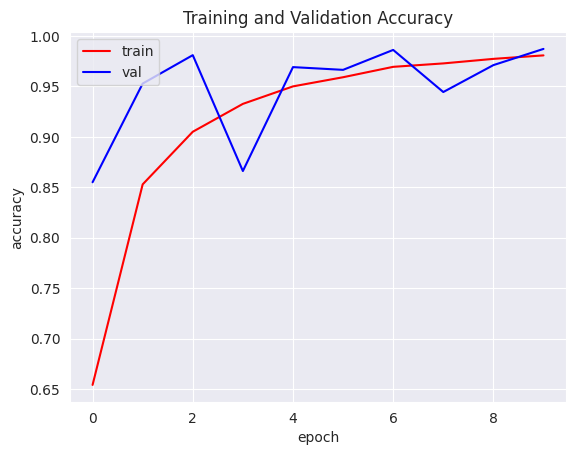

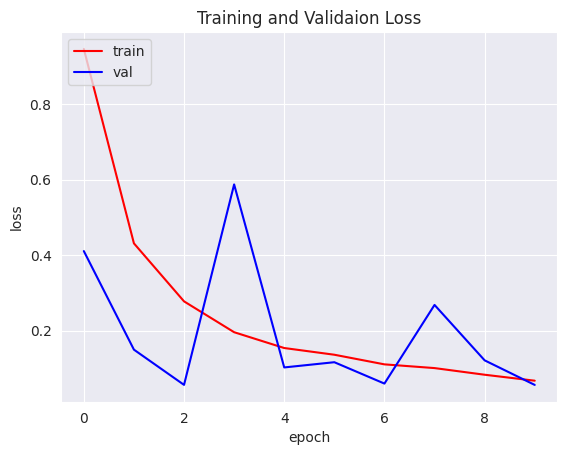

In [22]:
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

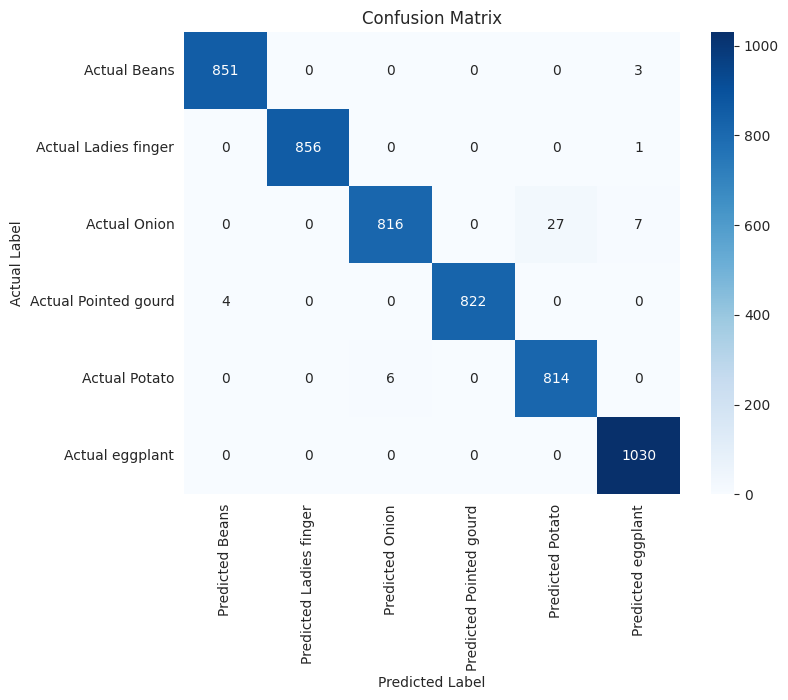


Classification Report:
               precision    recall  f1-score   support

        Beans     0.9953    0.9965    0.9959       854
Ladies finger     1.0000    0.9988    0.9994       857
        Onion     0.9927    0.9600    0.9761       850
Pointed gourd     1.0000    0.9952    0.9976       826
       Potato     0.9679    0.9927    0.9801       820
     eggplant     0.9894    1.0000    0.9947      1030

     accuracy                         0.9908      5237
    macro avg     0.9909    0.9905    0.9906      5237
 weighted avg     0.9909    0.9908    0.9908      5237



In [23]:
# Reset test generator
test_generator.reset()

# Prediksi model
preds_final = model_final.predict(test_generator, verbose=0)

# Konversi probabilitas ke kelas dengan argmax (untuk multi-class classification)
preds_final = np.argmax(preds_final, axis=1)

# Ambil label asli dari test_generator
y_true = test_generator.classes

# Nama kelas (sesuai urutan dalam generator)
class_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(y_true, preds_final)
cm_df = pd.DataFrame(cm, index=[f"Actual {cls}" for cls in class_labels], 
                          columns=[f"Predicted {cls}" for cls in class_labels])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, preds_final, target_names=class_labels, digits=4))


## Konversi Model

In [24]:
model_final.export('/kaggle/working/submission/saved_model')

Saved artifact at '/kaggle/working/submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138602992313872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138602992312112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138602992501856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138602992508368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138602992507664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138602992502208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138604430113104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138603033491264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138603022857872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138603022846960: TensorSpec(shape=(), dtype=tf.resource, name=

In [25]:
model_final.save("model.h5")


In [26]:
# Install tensorflowjs
!pip -q install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.4 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
pylibcudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which i

In [27]:
# Konversi Model SavedModel ke TFJS
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /kaggle/working/submission/saved_model \
    /kaggle/working/submission/model_tfjs

2025-02-10 07:13:18.706940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 07:13:18.728937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 07:13:18.735209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1739171605.740331     351 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739171605.740785     351 cuda_executor.cc:1015] succ

In [28]:
# Convert Model SavedModel to TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/kaggle/working/submission/saved_model')
tflite_model = converter.convert()
 
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [31]:
labels = [ "Beans", "Ladies finger", "Onion", "Pointed gourd", "Potato", "eggplant"]

# Simpan label ke file label.txt
with open('label.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

!mkdir tflite
!mv model.tflite label.txt tflite/
!mv tflite submission/

In [33]:
!pip -q freeze > requirements.txt

In [34]:
!zip -r model.zip submission model.h5 requirements.txt

  adding: submission/ (stored 0%)
  adding: submission/model_tfjs/ (stored 0%)
  adding: submission/model_tfjs/group1-shard2of6.bin (deflated 7%)
  adding: submission/model_tfjs/group1-shard5of6.bin (deflated 7%)
  adding: submission/model_tfjs/group1-shard4of6.bin (deflated 7%)
  adding: submission/model_tfjs/group1-shard3of6.bin (deflated 7%)
  adding: submission/model_tfjs/group1-shard1of6.bin (deflated 8%)
  adding: submission/model_tfjs/group1-shard6of6.bin (deflated 7%)
  adding: submission/model_tfjs/model.json (deflated 90%)
  adding: submission/tflite/ (stored 0%)
  adding: submission/tflite/model.tflite (deflated 7%)
  adding: submission/tflite/label.txt (stored 0%)
  adding: submission/saved_model/ (stored 0%)
  adding: submission/saved_model/saved_model.pb (deflated 87%)
  adding: submission/saved_model/assets/ (stored 0%)
  adding: submission/saved_model/variables/ (stored 0%)
  adding: submission/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: 

## Inference (Optional)

In [35]:
class_indices = train_generator.class_indices
print(class_indices)

{'Beans': 0, 'Ladies finger': 1, 'Onion': 2, 'Pointed gourd': 3, 'Potato': 4, 'eggplant': 5}


In [3]:
!pip -q install tensorflow


In [15]:
import tensorflow as tf
import requests

def images_preprocessing(filenames):
    image_tensors = []
    for filename in filenames:
        image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
        image = tf.image.resize(image, [150, 150])
        image = image / 255.0
        image_tensors.append(image)

    # Convert the list of images into a batch
    image_tensors = tf.stack(image_tensors)
    image_tensors = image_tensors.numpy().tolist()  # Convert to list format for JSON
    return image_tensors

# List of filenames for the images (Cat, Dog, Wild)
filenames = ['images/Beans.png', 'images/eggplant.png', 'images/ladies.png', 'images/pota.png', 'images/poited.png']

# Prepare the data (image batch) to be sent in the POST request
image_tensors = images_preprocessing(filenames=filenames)

json_data = {
    "instances": image_tensors
}

# Define the endpoint with format: http://localhost:8501/v1/models/MODEL_NAME:predict
endpoint = "http://localhost:8501/v1/models/rps_model:predict"
response = requests.post(endpoint, json=json_data)

# Process the response
response_json = response.json()
if 'predictions' in response_json:
    map_labels = {0: 'Beans', 1 : 'Ladies finger' , 2: 'Onion', 3: 'Pointed gourd', 4: 'Potato', 5: 'eggplant'}


    # Iterate through each prediction and print the result
    for i, prediction in enumerate(response_json['predictions']):
        predicted_label = tf.argmax(prediction).numpy()  # Get the predicted class
        print(f"Prediction for image {filenames[i]}: {map_labels[predicted_label]}")
else:
    print("Error: 'predictions' key not found in the response.")
    print("Response content:", response_json)

Prediction for image images/Beans.png: Beans
Prediction for image images/eggplant.png: eggplant
Prediction for image images/ladies.png: Ladies finger
Prediction for image images/pota.png: Potato
Prediction for image images/poited.png: Pointed gourd
